In [4]:
import torch
import torchvision
import json
from urllib.request import urlopen
from PIL import Image
import nltk
from collections import Counter
import statistics
import pandas as pd
import matplotlib
from tqdm import tqdm
import numpy as np
import math
import re
import zipfile
import wget
import bert_score
from IPython import display

В этой тетрадке архитектура аналогична архитектуре модели с ограниченным словарем, но здесь я взяла значительно больший объем словаря и предобученные эмбеддинги и обучала только генерацию памяти и веса lstm

In [ ]:
url = 'https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip'

In [ ]:
wget.download(url, 'wiki-news-300d-1M.vec.zip')

'wiki-news-300d-1M.vec.zip'

In [ ]:
#Функция скопирована из тетрадки с материалами для второй домашки
def load_embeddings(zip_path, filename, pad_token='PAD', max_words=100_000, verbose=True):
    
    vocab = dict()
    embeddings = list()

    with zipfile.ZipFile(zip_path) as zipped_file:
        with zipped_file.open(filename) as file_object:

            vocab_size, embedding_dim = file_object.readline().decode('utf-8').strip().split()

            vocab_size = int(vocab_size)
            embedding_dim = int(embedding_dim)
            
            # в файле 1 000 000 слов с векторами, давайте ограничим для простоты этот словарь
            max_words = vocab_size if max_words <= 0 else max_words
            
            # добавим пад токен и эмбеддинг в нашу матрицу эмбеддингов и словарь
            vocab[pad_token] = len(vocab)
            embeddings.append(np.zeros(embedding_dim))

            progress_bar = tqdm(total=max_words, disable=not verbose)

            for line in file_object:
                parts = line.decode('utf-8').strip().split()

                token = ' '.join(parts[:-embedding_dim]).lower()
                
                if token in vocab:
                    continue
                
                word_vector = np.array(list(map(float, parts[-embedding_dim:])))

                vocab[token] = len(vocab)
                embeddings.append(word_vector)

                progress_bar.update()
                
                if len(vocab) == max_words:
                    break

            progress_bar.close()

    embeddings = np.stack(embeddings)
    
    return vocab, embeddings

In [ ]:
vocab, embeddings = load_embeddings('./wiki-news-300d-1M.vec.zip', 'wiki-news-300d-1M.vec', max_words=100_000)


100%|█████████▉| 99999/100000 [00:12<00:00, 7867.53it/s]


In [ ]:
embeddings = torch.tensor(embeddings).float()

In [ ]:
from nltk.tokenize import wordpunct_tokenize

In [ ]:
with open('captions_train2014.json') as f:
    train_json = json.load(f)

In [ ]:
image_id2annotation_train = {}
for annotation in train_json['annotations']:
    image_id2annotation_train[annotation['image_id']] = annotation['caption']

In [ ]:
for image_id in image_id2annotation_train:
    annotation = image_id2annotation_train[image_id]
    annotation = annotation.lower()
    for beginning_regexp in ['^there is ', '^there are ', '^a ', '^an ', '^the ', '^image of ']:
        annotation = re.sub(beginning_regexp, '', annotation)
    image_id2annotation_train[image_id] = annotation

In [ ]:
vocab

{'PAD': 0,
 ',': 1,
 'the': 2,
 '.': 3,
 'and': 4,
 'of': 5,
 'to': 6,
 'in': 7,
 'a': 8,
 '"': 9,
 ':': 10,
 ')': 11,
 'that': 12,
 '(': 13,
 'is': 14,
 'for': 15,
 'on': 16,
 '*': 17,
 'with': 18,
 'as': 19,
 'it': 20,
 'or': 21,
 'was': 22,
 "'": 23,
 "'s": 24,
 'by': 25,
 'from': 26,
 'at': 27,
 'i': 28,
 'this': 29,
 'you': 30,
 '/': 31,
 'are': 32,
 '=': 33,
 'not': 34,
 '-': 35,
 'have': 36,
 '?': 37,
 'be': 38,
 'which': 39,
 ';': 40,
 'all': 41,
 'his': 42,
 'has': 43,
 'one': 44,
 'their': 45,
 'about': 46,
 'but': 47,
 'an': 48,
 '|': 49,
 'said': 50,
 'more': 51,
 'page': 52,
 'he': 53,
 'your': 54,
 'will': 55,
 'its': 56,
 'so': 57,
 'were': 58,
 'had': 59,
 'also': 60,
 'only': 61,
 'if': 62,
 'time': 63,
 'some': 64,
 'people': 65,
 'like': 66,
 'who': 67,
 'them': 68,
 'other': 69,
 'they': 70,
 'when': 71,
 'wikipedia': 72,
 'article': 73,
 'what': 74,
 '#': 75,
 'just': 76,
 '!': 77,
 'any': 78,
 'after': 79,
 'there': 80,
 'would': 81,
 'can': 82,
 'her': 83,
 'talk

In [ ]:
id2word = {vocab[token]: token for token in vocab}

In [ ]:
def decode(token_ids):
    return ' '.join([id2word[int(token_id)] for token_id in token_ids])

In [ ]:
class CaptionDataset(torch.utils.data.Dataset):
    def __init__(self, images, id2caption, vocab, max_len, eos_id, bos_id, pad_id, img_size=224):
        super().__init__()
        self.vocab = vocab
        self.pad_id = pad_id
        self.eos_id = eos_id
        self.bos_id = bos_id
        self.max_len = max_len
        self.loader = torchvision.transforms.Compose([
                        torchvision.transforms.Resize(img_size),
                        torchvision.transforms.CenterCrop(img_size),
                        torchvision.transforms.ToTensor(),
                        ]) 
        self.data = []
        for image in images:
            href = image['coco_url']
            caption = id2caption[image['id']]
            self.data.append((href, caption))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image_href, caption= self.data[idx]
        image = self.load_image(image_href)
        encoded_caption = [self.bos_id] + self.tokenization(caption) + [self.eos_id]
        encoded_caption = encoded_caption[:self.max_len]
        caption_pads = [self.pad_id for i in range(self.max_len - len(encoded_caption))]
        caption_tensor = torch.tensor(encoded_caption + caption_pads).long()
        return image, caption_tensor
        
    def load_image(self, href, volatile=False):
        image = Image.open(urlopen(href)).convert('RGB')
        image_tensor = self.loader(image).float()
        return torch.autograd.Variable(image_tensor, volatile=volatile).unsqueeze(0)

    def tokenization(self, text):
        tokens = wordpunct_tokenize(text)
        token_indices = [self.vocab[tok] for tok in tokens if tok in self.vocab]
        return token_indices

In [ ]:
pad_id = 0
eos_id = 0
bos_id = 3 #индекс точки в словаре

In [ ]:
train_dataset = CaptionDataset(train_json['images'], image_id2annotation_train, vocab, max_len=25, pad_id=pad_id, eos_id=eos_id, bos_id=bos_id)

In [ ]:
for image, caption in train_dataset:
    break

In [ ]:
alexnet_model = torchvision.models.alexnet(pretrained=True)
modified_classifier = torch.nn.Sequential(*list(alexnet_model.classifier.children())[:-1])
alexnet_model.classifier = modified_classifier

In [ ]:
embeddings.shape

torch.Size([100000, 300])

In [ ]:
class LstmBasedCaptionModelPretrainedEmbeddings(torch.nn.Module):
    def __init__(self, pretrained_image_encoder, pretrained_embeddings, padding_idx=0, weight_tying=True):
        super().__init__()
        #при обучении на выходе непосредственно из датасета потребуется добавлять размерность
        self.dataset_mode = True
        self.embedding_dim = pretrained_embeddings.shape[1]
        self.vocab_size = pretrained_embeddings.shape[0]

        self.image_encoder = pretrained_image_encoder
        for param in self.image_encoder.parameters():
            param.requires_grad = False
        #Узнаем размерность последнего слоя энкодера (если последний слой - релу, например, то это размерность предпоследнего слоя)
        for layer in self.image_encoder.classifier.children():
            if hasattr(layer, 'out_features'):
                self.read_image_dim = layer.out_features
        self.linear = torch.nn.Linear(self.read_image_dim, self.embedding_dim) 
        
        self.embedding_layer = torch.nn.Embedding.from_pretrained(embeddings, padding_idx=0)
        self.lstm = torch.nn.LSTM(input_size=self.embedding_dim, hidden_size=self.embedding_dim, batch_first=True)
        self.language_model_head = torch.nn.Linear(in_features=self.embedding_dim, out_features=self.vocab_size, bias=False)
        if weight_tying:
            self.language_model_head.weight = self.embedding_layer.weight
        
    def forward(self, image, correct_caption):
        read_image = self.image_encoder(image)
        read_image = self.linear(read_image)
        if self.dataset_mode:
            read_image = read_image.reshape(1,1,self.embedding_dim)
        memory = (read_image, read_image)
        
        embeddings = self.embedding_layer(correct_caption)
        if self.dataset_mode:
            seq_len = len(correct_caption)
            embeddings = embeddings.reshape(1,seq_len, self.embedding_dim)
        interpretation, _ = self.lstm(embeddings, memory)
        interpretation = self.language_model_head(interpretation)
        return interpretation

In [ ]:
model = LstmBasedCaptionModelPretrainedEmbeddings(alexnet_model, embeddings)

In [ ]:
criterion = torch.nn.CrossEntropyLoss(ignore_index=pad_id)

In [ ]:
optimizer = torch.optim.Adam([{'params': model.linear.parameters()},
                              {'params': model.lstm.parameters()}], 
                               lr = 1e-3)

In [ ]:
assert torch.cuda.is_available(), 'у вас не находится гпу'

device = torch.device('cuda')

In [ ]:
import time

In [ ]:
model.to(device)

LstmBasedCaptionModelPretrainedEmbeddings(
  (image_encoder): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0

In [ ]:
last_n_losses=200
clip = 5.
#train_losses = []
model.train()
for i in range(5805, len(train_dataset)):
    try:
        image, caption = train_dataset[i]
        image = image.to(device)
        caption = caption.to(device)
        prediction = model(image, caption)[:, :-1, :]
    
        correct_answer = caption[1:]
        loss = criterion(prediction[0], correct_answer)
        train_losses.append(float(loss))
        loss.backward()
        if len(train_losses)%10 == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
            optimizer.zero_grad()
        if len(train_losses) % 5000 == 0:
            torch.save(model.linear.state_dict(), f'lstm_based_caption_model_linear.pth')
            torch.save(model.lstm.state_dict(), f'lstm_based_caption_model_lstm.pth')
            print('Сохранение: ' + str(len(train_losses)))
    except Exception as e:
        time.sleep(5)
        print(e)
        print(len(train_losses))

Сохранение: 10000
Сохранение: 15000
Сохранение: 20000
Сохранение: 25000


In [ ]:
len(train_losses)

In [ ]:
torch.save(model.linear.state_dict(), f'lstm_based_caption_model_linear.pth')
torch.save(model.lstm.state_dict(), f'lstm_based_caption_model_lstm.pth')

In [ ]:
model.linear.load_state_dict(torch.load('lstm_based_caption_model_linear.pth'))

<All keys matched successfully>

In [ ]:
model.lstm.load_state_dict(torch.load('lstm_based_caption_model_lstm.pth'))

<All keys matched successfully>

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.figure(figsize=(14, 14))
plt.xlabel('Номер батча')
plt.ylabel('Значение функции потерь')
plt.title('Процесс обучения')
plt.plot(train_losses)

Для оценивания будем сохранять полную (не закодированую в индексы) корректную формулировку описания и ссылку

In [ ]:
class CaptionEvalDataset(torch.utils.data.Dataset):
    def __init__(self, images, id2caption, vocab, max_len, eos_id, bos_id, pad_id, img_size=224):
        super().__init__()
        self.vocab = vocab
        self.pad_id = pad_id
        self.eos_id = eos_id
        self.bos_id = bos_id
        self.max_len = max_len
        self.loader = torchvision.transforms.Compose([
                        torchvision.transforms.Resize(img_size),
                        torchvision.transforms.CenterCrop(img_size),
                        torchvision.transforms.ToTensor(),
                        ]) 
        self.data = []
        for image in images:
            href = image['coco_url']
            caption = id2caption[image['id']]
            self.data.append((href, caption))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image_href, caption= self.data[idx]
        image = self.load_image(image_href)
        return image, caption, image_href
        
    def load_image(self, href, volatile=False):
        image = Image.open(urlopen(href)).convert('RGB')
        image_tensor = self.loader(image).float()
        return torch.autograd.Variable(image_tensor, volatile=volatile).unsqueeze(0)

    def tokenization(self, text):
        tokens = wordpunct_tokenize(text)
        token_indices = [self.vocab[tok] for tok in tokens if tok in self.vocab]
        return token_indices

In [ ]:
with open('captions_val2014.json') as f:
    val_json = json.load(f)

In [ ]:
image_id2annotation_val = {}
for annotation in val_json['annotations']:
    image_id2annotation_val[annotation['image_id']] = annotation['caption']

In [ ]:
eval_dataset = CaptionEvalDataset(val_json['images'][:5000], image_id2annotation_val, vocab, max_len=25, pad_id=pad_id, eos_id=eos_id, bos_id=bos_id)

In [ ]:
def beam_search_gpu(model, image, device, n_best=3, vocab_size=1500, eos_id=2, bos_id=1, pad_id=0, unk_id=3, embedding_dim=200):
    #image_cuda = image.to(device)
    tech_poses = [pad_id, unk_id]
    with torch.no_grad():
        next_token = bos_id
        best_answers = []
        best_answers.append({'answer': [next_token], 'probability': 1})
        all_answers_are_finished = False
        read_image = model.image_encoder(image.cuda())
        read_image = model.linear(read_image).reshape(1,1, embedding_dim)
        memory = (read_image, read_image)
        while not all_answers_are_finished:
            current_step_best_options = []
            for answer_data in best_answers:
                answer = answer_data['answer']
                if answer[-1] == eos_id:
                    current_step_best_options.append(answer_data)
                else:
                    answer_beginning = model.embedding_layer(torch.unsqueeze(torch.tensor(answer),0))
                    #answer_beginning = answer_beginning.to(device)
                    lstm_output, _ = model.lstm(answer_beginning, memory)
                    last_token_interpretation = model.language_model_head(lstm_output)[0,-1,:]
                    for tech_pos in tech_poses:
                        last_token_interpretation[tech_pos] = -math.inf
                    
                    for i in range(n_best):
                        next_token = torch.argmax(last_token_interpretation)
                        next_token_probability = last_token_interpretation[next_token]
                        seq_probability = answer_data['probability']*next_token_probability
                        seq = answer + [next_token]
                        current_step_best_options.append({'answer': seq, 'probability':seq_probability})
                        last_token_interpretation[next_token] = -math.inf
                    if len(current_step_best_options) > n_best:
                        best_answers = sorted(current_step_best_options, key = lambda x: x['probability'], reverse=True)[:n_best]
                    else:
                        best_answers = current_step_best_options
                    
                    if all([answer_data['answer'][-1] == eos_id for answer_data in best_answers]):
                        all_answers_are_finished = True
        return best_answers[0]['answer']

In [ ]:
Сделаем датасет для генерации, который возвращает считанную картинку, текст без преобразований и ссылку, чтобы можно было вручную оценить адекватность описания

Так как в этот раз я сделала конец предложения равным паддингу, буду ограничивать длину текста при генерации

In [ ]:
def limited_beam_search(model, image, n_best=3, vocab_size=1500, eos_id=2, bos_id=1, pad_id=0, unk_id=3, embedding_dim=200, prediction_len=10):
    model.eval()
    tech_poses = [pad_id, unk_id]
    with torch.no_grad():
        next_token = bos_id
        best_answers = []
        best_answers.append({'answer': [next_token], 'probability': 1})
        read_image = model.image_encoder(image)
        read_image = model.linear(read_image).reshape(1,1, embedding_dim)
        memory = (read_image, read_image)
        for i in range(prediction_len):
            current_step_best_options = []
            for answer_data in best_answers:
                answer = answer_data['answer']
                if answer[-1] == eos_id:
                    current_step_best_options.append(answer_data)
                else:
                    answer_beginning = model.embedding_layer(torch.unsqueeze(torch.tensor(answer),0))
                    lstm_output, _ = model.lstm(answer_beginning, memory)
                    last_token_interpretation = model.language_model_head(lstm_output)[0,-1,:]
                    for tech_pos in tech_poses:
                        last_token_interpretation[tech_pos] = -math.inf
                    
                    for i in range(n_best):
                        next_token = torch.argmax(last_token_interpretation)
                        next_token_probability = last_token_interpretation[next_token]
                        seq_probability = answer_data['probability']*next_token_probability
                        seq = answer + [next_token]
                        current_step_best_options.append({'answer': seq, 'probability':seq_probability})
                        last_token_interpretation[next_token] = -math.inf
                    if len(current_step_best_options) > n_best:
                        best_answers = sorted(current_step_best_options, key = lambda x: x['probability'], reverse=True)[:n_best]
                    else:
                        best_answers = current_step_best_options
        return best_answers[0]['answer']

In [ ]:
model.eval()

LstmBasedCaptionModelPretrainedEmbeddings(
  (image_encoder): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0

In [ ]:
validation_predictions = pd.DataFrame({'correct': [], 'encoded_predicted': [], 'href': []})

with torch.no_grad():
    for i in tqdm(range(len(eval_dataset))):
        try:
            image, correct_caption, href = eval_dataset[i]
            encoded_prediction = limited_beam_search(model, image, vocab_size=len(vocab), eos_id=eos_id, bos_id=bos_id, pad_id=pad_id, unk_id=pad_id, embedding_dim=300, prediction_len=10)
            validation_predictions.loc[len(validation_predictions)] = [correct_caption, encoded_prediction, href]
        except Exception as e:
            print(e)

  0%|          | 0/5000 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
100%|██████████| 5000/5000 [2:01:10<00:00,  1.45s/it]  


In [ ]:
validation_predictions['decoded_predicted_text'] = validation_predictions['encoded_predicted'].apply(lambda x: decode(x))
#validation_predictions['decoded_predicted_text'] = validation_predictions['decoded_predicted'].apply(lambda x: ' '.join(x))

In [ ]:
validation_predictions.to_csv('captioning_pretrained_embeddings.predictions.csv')

In [ ]:
validation_predictions

,correct,encoded_predicted,href,decoded_predicted_text
0,A man in a red shirt and a red hat is on a mot...,"[3, tensor(937), tensor(3991), tensor(16), ten...",http://images.cocodataset.org/val2014/COCO_val...,. woman sitting on a sidewalk on a sidewalk . .
1,A woman marking a cake with the back of a chef...,"[3, tensor(8080), tensor(18), tensor(8), tenso...",http://images.cocodataset.org/val2014/COCO_val...,. bathroom with a bathroom with a bathroom . . .
2,A boy holding an umbrella while standing next ...,"[3, tensor(2182), tensor(3991), tensor(16), te...",http://images.cocodataset.org/val2014/COCO_val...,. dog sitting on a grass with a grass field .
3,a young kid with head phones on using a computer,"[3, tensor(937), tensor(3991), tensor(16), ten...",http://images.cocodataset.org/val2014/COCO_val...,. woman sitting on a sitting on a table . .
4,A small child wearing headphones plays on the ...,"[3, tensor(937), tensor(3991), tensor(16), ten...",http://images.cocodataset.org/val2014/COCO_val...,. woman sitting on a sitting on a table . .
...,...,...,...,...
4995,A man that is standing in the dirt with a bat.,"[3, tensor(937), tensor(3991), tensor(16), ten...",http://images.cocodataset.org/val2014/COCO_val...,. woman sitting on a tennis tennis tennis . . .
4996,"Travis d'Arnaud, baseball catcher for the New ...","[3, tensor(937), tensor(3991), tensor(16), ten...",http://images.cocodataset.org/val2014/COCO_val...,. woman sitting on a bench on a tennis tennis .
4997,there is a baseball player at bat that is prep...,"[3, tensor(937), tensor(3991), tensor(16), ten...",http://images.cocodataset.org/val2014/COCO_val...,. woman sitting on a grass field with a grass .
4998,A batter hit the ball and begins to run to the...,"[3, tensor(937), tensor(3991), tensor(16), ten...",http://images.cocodataset.org/val2014/COCO_val...,. woman sitting on a bench with a tennis tennis .


In [5]:
from google.colab import files
files.upload()

Saving captioning_pretrained_embeddings.predictions2.csv to captioning_pretrained_embeddings.predictions2.csv


{'captioning_pretrained_embeddings.predictions2.csv': b',correct,encoded_predicted,href,decoded_predicted_text;\r\n"0,A man in a red shirt and a red hat is on a motorcycle on a hill side.,""[3, tensor(937), tensor(3991), tensor(16), tensor(8), tensor(17911), tensor(16), tensor(8), tensor(17911), tensor(3), tensor(3)]"",http://images.cocodataset.org/val2014/COCO_val2014_000000391895.jpg,. woman sitting on a sidewalk on a sidewalk . .";\r\n"1,A woman marking a cake with the back of a chef\'s knife. ,""[3, tensor(8080), tensor(18), tensor(8), tensor(8080), tensor(18), tensor(8), tensor(8080), tensor(3), tensor(3), tensor(3)]"",http://images.cocodataset.org/val2014/COCO_val2014_000000522418.jpg,. bathroom with a bathroom with a bathroom . . .";\r\n"2,A boy holding an umbrella while standing next to livestock.,""[3, tensor(2182), tensor(3991), tensor(16), tensor(8), tensor(4948), tensor(18), tensor(8), tensor(4948), tensor(403), tensor(3)]"",http://images.cocodataset.org/val2014/COCO_val201

In [8]:
with open('captioning_pretrained_embeddings.predictions2.csv') as f:
    lines = f.readlines()

In [11]:
import re

Идея сохранять массивы в csv с разделителем-запятой была плохой, но мне все равно надо было поместить нужные элементы в массивы

In [28]:
for line in lines:
    line = re.sub('encoded_predicted,', '', line)
    line = re.sub('""[/[^/]+/]]""', '', line)

In [34]:
well_formatted_data = []
for line in lines:
    line_parts = line.split(',')
    if len(line_parts) >=4:
        meaningfull_columns = [line_parts[1], line_parts[-2], line_parts[-1]]
        well_formatted_data.append(meaningfull_columns)

In [35]:
well_formatted_data

[['correct', 'href', 'decoded_predicted_text;\n'],
 ['A man in a red shirt and a red hat is on a motorcycle on a hill side.',
  'http://images.cocodataset.org/val2014/COCO_val2014_000000391895.jpg',
  '. woman sitting on a sidewalk on a sidewalk . .";\n'],
 ["A woman marking a cake with the back of a chef's knife. ",
  'http://images.cocodataset.org/val2014/COCO_val2014_000000522418.jpg',
  '. bathroom with a bathroom with a bathroom . . .";\n'],
 ['A boy holding an umbrella while standing next to livestock.',
  'http://images.cocodataset.org/val2014/COCO_val2014_000000184613.jpg',
  '. dog sitting on a grass with a grass field .";\n'],
 ['a young kid with head phones on using a computer ',
  'http://images.cocodataset.org/val2014/COCO_val2014_000000318219.jpg',
  '. woman sitting on a sitting on a table . .";\n'],
 ['A small child wearing headphones plays on the computer.',
  'http://images.cocodataset.org/val2014/COCO_val2014_000000554625.jpg',
  '. woman sitting on a sitting on a ta

Кажется, что модель чуть лучше, чем модель с предобученными эмбеддингами, определяет соответствие слов сущностям, но строит менее грамматичные предложения с большим количеством повторов

 ['A kitchen with wooden cabinets and black appliances.',
  'http://images.cocodataset.org/val2014/COCO_val2014_000000193271.jpg',
  '. bathroom with a bathroom with a bathroom . . .";\n'] - плохо, но модель поняла, что это про интерьер

   ['A small shower behind a small bathroom sink.',
  'http://images.cocodataset.org/val2014/COCO_val2014_000000579003.jpg',
  '. bathroom with a bathroom with a bathroom . . .";\n']

Посчитаем метрики

In [39]:
!pip install nltk

In [54]:
validation_predictions = pd.DataFrame({'correct':[], 'decoded_predicted_text': []})
for correct, href, predicted in well_formatted_data:
    validation_predictions.loc[len(validation_predictions)] = [correct, predicted]


In [55]:
from nltk.tokenize import word_tokenize

In [56]:
def apply_bleu(hypothesis, referense):
    hypothesis_tokens = [token for token in word_tokenize(hypothesis) if token.isalpha()]
    referense_tokens = [token for token in word_tokenize(referense) if token.isalpha()]
    BLEUscore = nltk.translate.bleu_score.sentence_bleu([referense_tokens], hypothesis_tokens, weights = [1])
    return BLEUscore

In [59]:
validation_predictions['blew'] = [apply_bleu(row['correct'], row['decoded_predicted_text']) for i, row in validation_predictions.iterrows()]

In [60]:
validation_predictions['blew'] .describe()

count    5002.000000
mean        0.166643
std         0.117139
min         0.000000
25%         0.090909
50%         0.153846
75%         0.250000
max         0.625000
Name: blew, dtype: float64

В целом метрики чуть лучше, чем с обучением эмбеддингов (все параметры, кроме самого успешного результата

In [61]:
clean_predictions = []
clean_references = []
for i, row in validation_predictions.iterrows():
    prediction = row['decoded_predicted_text']
    clean_prediction = ' '.join([token for token in word_tokenize(prediction) if token.isalpha()])
    clean_predictions.append(clean_prediction)

    reference = row['correct']
    clean_reference = ' '.join([token for token in word_tokenize(reference) if token.isalpha()])
    clean_references.append([clean_reference])

In [62]:
P, R, F1 = bert_score.score(clean_predictions, clean_references, lang='en', verbose=True)


calculating scores...
computing bert embedding.



computing greedy matching.



done in 712.74 seconds, 7.02 sentences/sec


In [63]:
import matplotlib.pyplot as plt

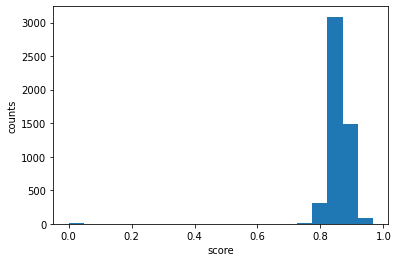

In [64]:
plt.hist(F1, bins=20)
plt.xlabel("score")
plt.ylabel("counts")
plt.show()

Bert score сопоставим с решением на ограниченном словаре, медианное значение в текущем решении немного ниже

In [66]:
clean_predictions = []
for i, row in validation_predictions.iterrows():
    prediction = row['decoded_predicted_text']
    clean_prediction = ' '.join([token for token in word_tokenize(prediction) if token.isalpha()])
    clean_predictions.append(clean_prediction)
clean_predictions_counter = Counter(clean_predictions)

Как и у предыдущей модели, повторов много

In [67]:
clean_predictions_counter.most_common(len(clean_predictions_counter))

[('woman sitting on a desk on a table', 344),
 ('bathroom with a bathroom with a bathroom', 336),
 ('woman sitting on a sitting on a table', 289),
 ('woman sitting on a surfboard on a beach', 170),
 ('woman sitting on a bench on a sidewalk', 161),
 ('woman sitting on a tennis tennis tennis', 140),
 ('dog sitting on a table on a table', 132),
 ('blue bus bus on a bus on a bus', 117),
 ('woman sitting on a bench on a tennis tennis', 117),
 ('pizza on a plate on a table', 92),
 ('dog sitting on a desk on a table', 90),
 ('woman sitting on a sidewalk on a sidewalk', 89),
 ('woman sitting on a table on a table', 88),
 ('pizza on a table on a table', 67),
 ('dog sitting on a table with a windowsill', 56),
 ('plate with a pizza on a table', 56),
 ('woman sitting on a desk on a desk on a', 54),
 ('dog sitting on a grass on a grass', 53),
 ('woman sitting on a tennis tennis tennis tennis', 51),
 ('dog sitting on a bench on a sidewalk', 47),
 ('woman sitting on a surfboard on a surfboard', 47),
